In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [ ]:
## apply various technical indicators , we can try out combination of various technical indicators but we use EMA, RSI, ATR

# Building the model

In [69]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputClassifier
import numpy as np
from sklearn.neighbors import NearestNeighbors

def model(ticker,start_date='2020-01-01',end_date='2025-03-01',horizon=1,k_neighbours=5,rsi_window=14,ema_window=100, atr_window=14):
    def prepare_input(ticker,horizon,rsi_window,ema_window,atr_window):
      """
        Arguments:
        ticker (from yfinance)
        dates for downloading stock datta (we are downloading daily data)
        horizon = Period for which you want to forecast '1d','1w''1mo',etc (Enter value in no. of days)
        k_neighbours : used for knn purpose in finding mean of k nearest neighbors
        rsi_window,ema_window , atr_window are the spans over which calculations are done

      """
      data = yf.download(ticker, start= start_date, end= end_date)
      def calculate_rsi(data, ticker, rsi_window): #for momentum
        """
        Calculate the Relative Strength Index (RSI) for a given dataset.

        Parameters:
        ----------
        df : pandas.DataFrame
            DataFrame containing the 'close' prices column.
        length : int
            The lookback period for calculating RSI.

        Returns:
        -------
        pandas.Series
            A Series containing the RSI values for the specified input data.
        """
        delta = data[('Close',ticker)].diff(1)
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=rsi_window).mean()
        avg_loss = pd.Series(loss).rolling(window=rsi_window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
      def calculate_atr(data,ticker, window=14):
        """
        Calculate the Average True Range (ATR).

        ATR is a measure of market volatility.

        Parameters:
        ----------
        data : pandas.DataFrame
            A DataFrame containing at least the 'high', 'low', and 'close' columns.
        window : int, optional
            The rolling window period for calculating the ATR. Default is 14.

        Returns:
        -------
        atr : pandas.Series
            The Average True Range values.
        """
        tr1 = data[('High',ticker)] - data[('Low',ticker)]
        tr2 = abs(data[('High',ticker)] - data[('Close',ticker)].shift(1))
        tr3 = abs(data[('Low',ticker)] - data[('Close',ticker)].shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(window).mean()
        return atr

      ema = data[['Close']].ewm(span=ema_window, adjust=False).mean().fillna(method='bfill')
      data['EMA'] = ema

      rsi = calculate_rsi(data,ticker,rsi_window)
      data['RSI']=np.nan
      for i in range(len(data)):
          # Access rsi using the numerical index i
          data.iloc[i, -1] = rsi.iloc[i]

      atr = calculate_atr(data,ticker,atr_window)
      data['ATR']=np.nan
      for i in range(len(data)):
          # Access rsi using the numerical index i
          data.iloc[i, -1] = atr.iloc[i]
      data['y_rsi'] = np.where(data['RSI'].shift(horizon) > data['RSI'], -1, 1)
      data['y_atr'] = np.where(data['ATR'].shift(horizon) > data['ATR'], -1, 1)
      data['y_ema'] = np.where(data['EMA'].shift(horizon) > data['EMA'], -1, 1)
      data.dropna(inplace=True)
      return data


    data = prepare_input(ticker,horizon,rsi_window,ema_window,atr_window)
    scaler = StandardScaler()  ## giving better results than MinMax
    # Use a list of column names to select multiple columns
    X = data[['EMA', 'RSI', 'ATR']]
    y = data[['y_ema', 'y_rsi', 'y_atr']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    model = MultiOutputClassifier(SVC())
    model.fit(X_train, y_train)
    print(model.score(X_test, y_test))
    # Create a new DataFrame for predictions
    predictions_df = pd.DataFrame(index=y.index)  # Use y_test.index to align predictions
    predictions_df["y_pred_ema"] = model.predict(X)[:, 0]
    predictions_df["y_pred_rsi"] = model.predict(X)[:, 1]
    predictions_df["y_pred_atr"] = model.predict(X)[:, 2]

    # Merge the predictions back into the original DataFrame
    def evaluate_predictions(y_true, y_pred, X_test, k=k_neighbours):
        """
        Evaluates model predictions by comparing them to actual outputs.

        For matched predictions, it finds the k-nearest neighbors in the feature space
        and calculates their mean.

        Args:
            data: dataset of ticker data (pandas DataFrame).
            y_true: Actual output values (numpy array).
            y_pred: Predicted output values (numpy array).
            X_test: Feature data for the test set (numpy array).
            k: Number of nearest neighbors to consider.

        Returns:
            A pandas Series containing the mean values of the k-nearest neighbors for
            correctly predicted instances, aligned with the original index.
            Returns a Series filled with NaN if there are no correct predictions.
        """

        matched_indices = []
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                matched_indices.append(i)
        matched_indices = np.array(matched_indices)

        # Create a Series filled with NaN
        result_series = pd.Series(np.nan, index=data.index)

        if matched_indices.size > 0:  # Proceed only if there are matches
            matched_X = X_test[matched_indices]
            X_test = X_test.reshape(-1, 1)
            matched_X = matched_X.reshape(-1, 1)

            knn = NearestNeighbors(n_neighbors=k)
            knn.fit(X_test)

            _, indices = knn.kneighbors(matched_X)

            mean_values = []
            for i in range(len(matched_X)):
                neighbors_indices = indices[i]
                neighbors_values = X_test[neighbors_indices]  # Changed to X_test
                mean_values.append(np.mean(neighbors_values, axis=0))  # Changed to X_test

            # Assign the calculated mean values to the corresponding indices
            # in the result Series.
            result_series.iloc[matched_indices] = [x[0] for x in mean_values] # Changed this line

        return result_series

    # Concatenate predictions_df with data before calling evaluate_predictions
    data = pd.concat([data, predictions_df], axis=1)  # axis=1 for horizontal, axis=0 for vertical

    # Access prediction columns using single-level indexing
    y_pred_atr = np.array(data["y_pred_atr"])
    y_pred_rsi = np.array(data["y_pred_rsi"])
    y_pred_ema = np.array(data["y_pred_ema"])
    y_true_atr = np.array(data[("y_atr", '')])
    y_true_rsi = np.array(data[("y_rsi", '')])
    y_true_ema = np.array(data[("y_ema", '')])
    x_atr = np.array(data[("ATR", '')])
    x_rsi = np.array(data[("RSI", '')])
    x_ema = np.array(data[("EMA", '')])
    #print(evaluate_predictions(y_true_ema, y_pred_ema, x_atr))

    predictions_df["Forecasted_EMA"] = evaluate_predictions(y_true_ema, y_pred_ema, x_ema)
    predictions_df["Forecasted_RSI"] = evaluate_predictions(y_true_rsi, y_pred_rsi, x_rsi)
    predictions_df["Forecasted_ATR"] = evaluate_predictions(y_true_atr, y_pred_atr, x_atr)

    data = pd.concat([data, predictions_df], axis=1)  # axis=1 for horizontal, axis=0 for vertical
    columns_to_drop = [
        ("y_atr", ""), ("y_rsi", ""), ("y_ema", ""),
        "y_pred_atr", "y_pred_rsi", "y_pred_ema"
    ]
    data = data.drop(columns=columns_to_drop, errors='ignore') # Added errors='ignore' to handle potential KeyError
    def check_accuracy():
      def rmse(y_true, y_predicted):
        return np.sqrt(np.mean((y_true - y_predicted)**2))
      rmse_ema = rmse(y_true_ema, y_pred_ema)
      print(f"RMSE for EMA: {rmse_ema}")

      # Calculate RMSE for RSI
      rmse_rsi = rmse(y_true_rsi, y_pred_rsi)
      print(f"RMSE for RSI: {rmse_rsi}")


      # Calculate RMSE for ATR
      rmse_atr = rmse(y_true_atr, y_pred_atr)
      print(f"RMSE for ATR: {rmse_atr}")
    # data.dropna(inplace=True)
    data.fillna(method='bfill',inplace=True)
    return data

In [70]:
model('AAPL')

[*********************100%***********************]  1 of 1 completed
<ipython-input-69-df35b2bdd474>:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ema = data[['Close']].ewm(span=ema_window, adjust=False).mean().fillna(method='bfill')


0.245136186770428


<ipython-input-69-df35b2bdd474>:199: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill',inplace=True)


,"(Close, AAPL)","(High, AAPL)","(Low, AAPL)","(Open, AAPL)","(Volume, AAPL)","(EMA, )","(RSI, )","(ATR, )",Forecasted_EMA,Forecasted_RSI,Forecasted_ATR
Date,,,,,,,,,,,
2020-01-22,76.916580,77.470994,76.822156,77.129626,101832400,73.270161,70.868457,1.239747,73.237627,59.568852,1.290385
2020-01-23,77.286987,77.366879,76.420249,76.969831,104472000,73.349702,71.902560,1.213808,73.342912,59.568852,1.290385
2020-01-24,77.064270,78.279632,76.873005,77.533953,146537600,73.423257,75.401579,1.243725,73.430905,59.568852,1.290385
2020-01-27,74.798164,75.480893,73.812798,75.066897,161940000,73.450483,59.513408,1.351289,73.465454,59.568852,1.420487
2020-01-28,76.914154,77.086046,75.582580,75.681843,162234000,73.519071,67.412506,1.455567,73.506688,63.886464,1.465864
...,...,...,...,...,...,...,...,...,...,...,...
2025-02-24,247.100006,248.860001,244.419998,244.929993,51326400,233.876923,80.231290,4.733345,234.041213,76.540661,4.875322
2025-02-25,247.039993,250.000000,244.910004,248.000000,48013300,234.137578,76.585168,4.634566,234.213228,76.540661,4.875322
2025-02-26,240.360001,244.979996,239.130005,244.330002,44433600,234.260795,62.116289,4.876350,234.213228,62.126557,4.875322


[*********************100%***********************]  1 of 1 completed
<ipython-input-69-df35b2bdd474>:69: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ema = data[['Close']].ewm(span=ema_window, adjust=False).mean().fillna(method='bfill')


0.245136186770428


<ipython-input-69-df35b2bdd474>:199: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill',inplace=True)


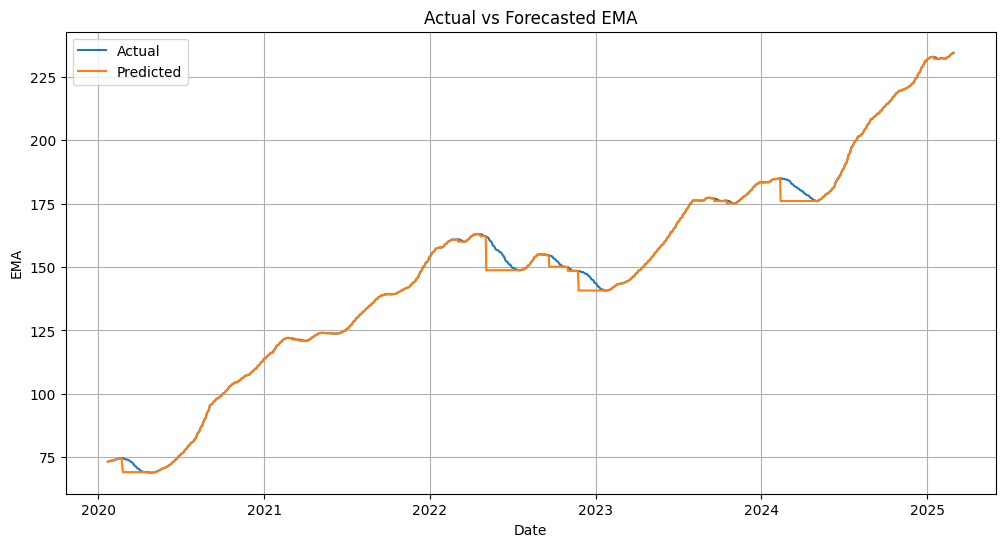

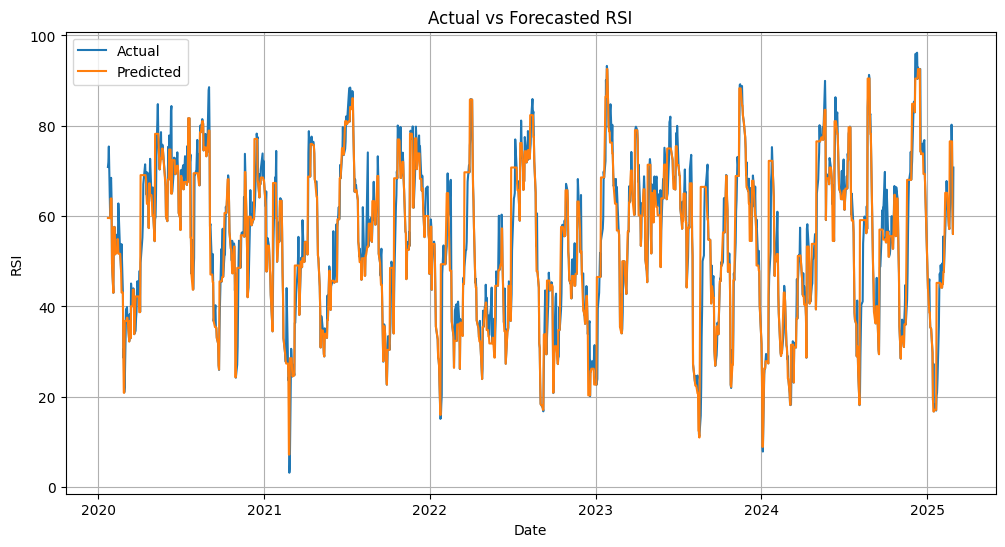

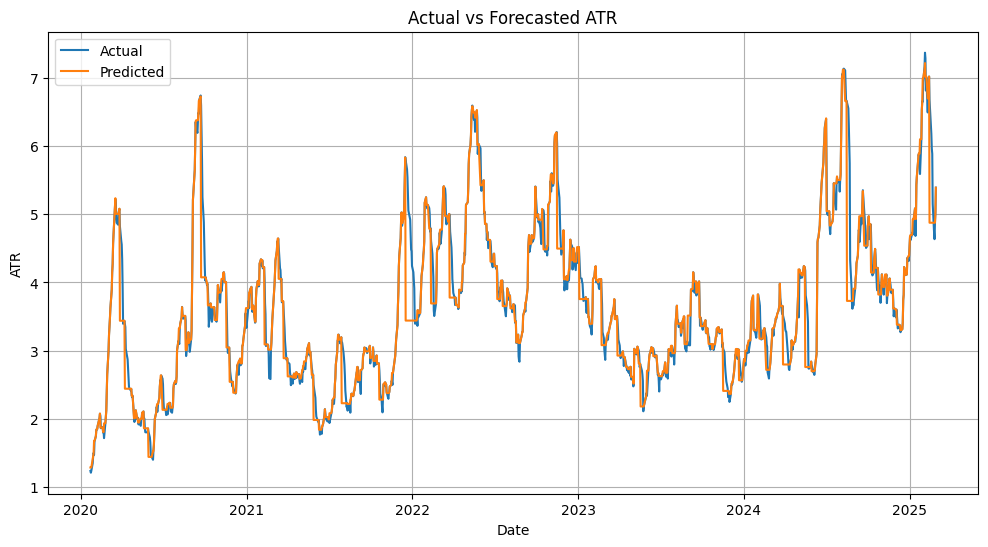

In [79]:
# prompt: generate graphs for my forecasted vs actual values by my model

import matplotlib.pyplot as plt
def plot_forecasted_vs_actual(data, column_name):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data[(column_name,'')], label='Actual')
    plt.plot(data.index, data[f"Forecasted_{column_name}"] ,label='Predicted')
    plt.xlabel('Date')
    plt.ylabel(column_name)
    plt.title(f'Actual vs Forecasted {column_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming 'data' is the DataFrame returned by your 'model' function
data = model('AAPL') # Call your model function

# Plot for EMA
plot_forecasted_vs_actual(data, 'EMA')

# Plot for RSI
plot_forecasted_vs_actual(data, 'RSI')

# Plot for ATR
plot_forecasted_vs_actual(data, 'ATR')


# Implementing with a simple trading strategy

compare forecasted ema and actual ema
We also confirm our buy signal with rsi <70 (rsi>70 means overbought stock)... and sell signal with rsi >30... we have also set an atr threshold

In [67]:
def trading_strategy(data, atr_threshold=2.5, rsi_buy_threshold=70, rsi_sell_threshold=30):

    # Generate signals based on forecasted values
    signals = pd.DataFrame(index=data.index)
    signals['Action'] = 0 # No action ... hold

    for i in range(len(data)):
        if data['Forecasted_EMA'].iloc[i] > data[('EMA','')].iloc[i] and data['Forecasted_ATR'].iloc[i] > atr_threshold and data['Forecasted_RSI'].iloc[i] < rsi_buy_threshold:
            signals.loc[data.index[i], 'Action'] = -1
        elif data['Forecasted_EMA'].iloc[i] < data[('EMA','')].iloc[i] and data['Forecasted_ATR'].iloc[i] > atr_threshold and data['Forecasted_RSI'].iloc[i] > rsi_sell_threshold:
            signals.loc[data.index[i], 'Action'] = 1

    data = pd.concat([data, signals], axis=1)  # axis=1 for horizontal, axis=0 for vertical

    # Accessing the 'Close' column using tuple indexing for returns calculations
    data["returns_b&h"]=np.log(data.iloc[:,0]/data.iloc[:,0].shift(1))
    data["my_returns"]=np.log(data.iloc[:,0]/data.iloc[:,0].shift(1))*data["Action"]

    my_return= np.exp(data['my_returns'].sum())
    basic_return = np.exp(data['returns_b&h'].sum())
    print(f"My Returns are {my_return} v/s simple buy and hold returns are {basic_return}")
    return data

In [61]:
df=model('AAPL').tail(15)

[*********************100%***********************]  1 of 1 completed
<ipython-input-14-75d3e4801774>:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ema = data[['Close']].ewm(span=ema_window, adjust=False).mean().fillna(method='bfill')


0.245136186770428


<ipython-input-14-75d3e4801774>:198: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill',inplace=True)


In [68]:
trading_strategy(df)

My Returns are 0.9765990634819376 v/s simple buy and hold returns are 1.0635939446941716


,"(Close, AAPL)","(High, AAPL)","(Low, AAPL)","(Open, AAPL)","(Volume, AAPL)","(EMA, )","(RSI, )","(ATR, )",Forecasted_EMA,Forecasted_RSI,Forecasted_ATR,Action,returns_b&h,my_returns
Date,,,,,,,,,,,,,,
2025-02-07,227.380005,233.743004,227.010401,232.344548,39707200,232.205623,47.600579,7.005156,232.112319,47.628780,7.015428,1,NaN,NaN
2025-02-10,227.649994,230.589996,227.199997,229.570007,33115600,232.115413,56.277156,6.490988,232.112319,65.145763,6.695246,1,0.001187,0.001187
2025-02-11,232.619995,235.229996,228.130005,228.199997,53718400,232.125405,59.899979,6.723470,232.112319,65.145763,6.695246,1,0.021597,0.021597
2025-02-12,236.869995,236.960007,230.679993,231.199997,45243300,232.219357,63.532549,6.834557,232.221435,65.145763,6.836136,-1,0.018105,-0.018105
2025-02-13,241.529999,242.339996,235.570007,236.910004,53614100,232.403726,67.753111,7.017030,232.354152,65.145763,7.015428,1,0.019482,0.019482
2025-02-14,244.600006,245.550003,240.990005,241.250000,40896200,232.645237,65.145573,6.674194,232.683209,65.145763,4.875322,-1,0.012631,-0.012631
2025-02-18,244.470001,245.179993,241.839996,244.149994,48822500,232.879390,57.847549,6.175718,232.841892,57.833872,4.875322,1,-0.000532,-0.000532
2025-02-19,244.869995,246.009995,243.160004,244.660004,32204200,233.116828,57.120857,5.961890,233.016092,57.139368,4.875322,1,0.001635,0.001635
2025-02-20,245.830002,246.779999,244.289993,244.940002,32316900,233.368574,60.699232,5.884315,233.175985,76.540661,4.875322,1,0.003913,0.003913
